In [1]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import (
    Conv2D,
    BatchNormalization,
    LeakyReLU,
    MaxPooling2D,
    Flatten,
    Dense,
    Dropout,
    GlobalAveragePooling2D
)
from tensorflow.keras import layers, models
from tensorflow.keras.layers import Input, Conv2D, Flatten, Dense
from tensorflow.keras.preprocessing import image
import tensorflow as tf
import numpy as np
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Model
from matplotlib import pyplot as plt
import glob


In [2]:
# Install the Kaggle API
!pip install kaggle

# Create a Kaggle folder if it doesn't exist
!mkdir -p ~/.kaggle

In [3]:
from google.colab import drive

drive.mount('/content/drive/')

Mounted at /content/drive/


In [4]:
!cp kaggle.json ~/.kaggle/kaggle.json
!chmod 600 ~/.kaggle/kaggle.json  # Change permissions

cp: cannot stat 'kaggle.json': No such file or directory
chmod: cannot access '/root/.kaggle/kaggle.json': No such file or directory


In [5]:
!kaggle datasets download ananthu017/emotion-detection-fer -p /content/ --unzip


Dataset URL: https://www.kaggle.com/datasets/ananthu017/emotion-detection-fer
License(s): CC0-1.0
 83% 54.0M/65.2M [00:00<00:00, 91.2MB/s]
100% 65.2M/65.2M [00:00<00:00, 103MB/s] 


In [6]:
train_dir = "/content/train/"
test_dir = "/content/test/"

CLASS_NAMES = ['angry', 'disgusted', 'fearful', 'happy', 'neutral', 'sad', 'surprised']


In [7]:
train_dataset = tf.keras.utils.image_dataset_from_directory(
    train_dir,
    labels="inferred",
    label_mode="int",
    class_names=CLASS_NAMES,
    color_mode="rgb",
    batch_size=32,  # Only include this once
    image_size=(224, 224),
    shuffle=True,
    seed=99,
)


Found 28709 files belonging to 7 classes.


In [8]:
val_dataset = tf.keras.utils.image_dataset_from_directory(
    test_dir,
    labels="inferred",
    label_mode="int",
    class_names=CLASS_NAMES,
    color_mode="rgb",
    batch_size=32,  # Only include this once
    image_size=(224, 224),
    shuffle=True,
    seed=99,
)


Found 7178 files belonging to 7 classes.


# Dataset Visualization


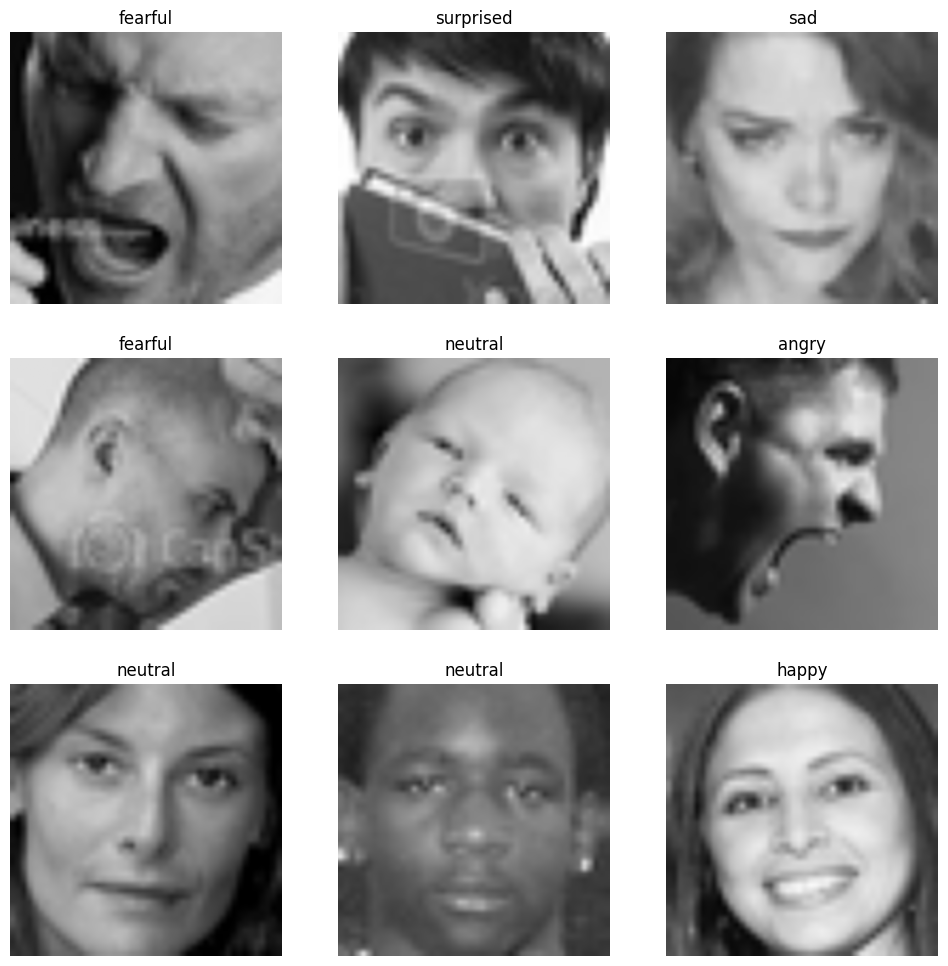

In [9]:
plt.figure(figsize =(12,12))

for images, label in train_dataset.take(1):
  for i in range(9):
    ax = plt.subplot(3,3,i+1)
    plt.imshow(images[i]/255.)
    plt.title(CLASS_NAMES[label[i]])
    plt.axis("off")

In [10]:
# Prefetch datasets for better performance
training_dataset = train_dataset.prefetch(tf.data.AUTOTUNE)
validation_dataset = val_dataset.prefetch(tf.data.AUTOTUNE)


# Define the data augmentation layers
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip("horizontal_and_vertical"),  # Randomly flip images
    tf.keras.layers.RandomRotation(0.2),                   # Randomly rotate images
    tf.keras.layers.RandomZoom(0.1),                       # Randomly zoom images
    tf.keras.layers.RandomTranslation(0.1, 0.1),           # Randomly translate images
    tf.keras.layers.RandomContrast(0.2),                   # Adjust image contrast
    tf.keras.layers.RandomBrightness(0.2),                 # Adjust image brightness
], name="data_augmentation")


# Resize and rescale layers
resize_rescale_layers = tf.keras.Sequential([
    tf.keras.layers.Resizing(256, 256),
    tf.keras.layers.Rescaling(1.0 / 255),
])

# Combine augmentation and preprocessing layers into a pipeline
augmentation_pipeline = tf.keras.Sequential([
    tf.keras.layers.InputLayer(input_shape=(256, 256, 3)),  # Explicit input shape
    data_augmentation,
    resize_rescale_layers,
], name="augmentation_pipeline")

# Apply transformations to train and validation datasets
train_dataset = training_dataset.map(lambda x, y: (resize_rescale_layers(x), y))
val_dataset = validation_dataset.map(lambda x, y: (resize_rescale_layers(x), y))  # No augmentation on validation

# Prefetch datasets for better performance
train_dataset = train_dataset.prefetch(tf.data.AUTOTUNE)
val_dataset = val_dataset.prefetch(tf.data.AUTOTUNE)

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/input_layer.py:26: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


# Modeling


In [11]:
CONFIGURATION = {
    'BATCH_SIZE':32,
    'IM_SIZE': 256,
    'LEARNING_RATE':0.001,
    'N_EPOCHS': 25,
    'DROPOUT_RATE':0.0,
    'REGULARIZATION_RATE':0.0,
    'N_FILTERS':6,
    'KERNEL_SIZE': 3,
    'N_STRIDES': 1,
    'POOL_SIZE' : 2,
    'N_DENSE_1':100,
    'N_DENSE_2': 10,
    'NUM_CLASSES' : 7
}


# Transfer Learning with VGG16


In [12]:
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Model

from tensorflow.keras import layers, models
from keras.regularizers import l2

In [13]:
vgg = VGG16(
    input_shape=(256, 256, 3),
    weights='imagenet',
    include_top=False

)


58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [14]:
for layer in vgg.layers:
  layer.trainable = False

In [15]:
# Add global average pooling to reduce dimensionality
x = GlobalAveragePooling2D()(vgg.output)

# # Add fully connected layers with L2 regularization and dropout for better generalization
# x = Dense(128, activation='relu', kernel_regularizer=l2(0.01))(x)
# x = BatchNormalization()(x)  # Add BatchNormalization to stabilize training
# x = Dropout(0.2)(x)

# Output layer for multi-class classification
x = Dense(7, activation='softmax')(x)

In [16]:
model = Model(
    inputs = vgg.input,
    outputs = x
)

In [17]:
model.summary()

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_3 (InputLayer)           │ (None, 256, 256, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv1 (Conv2D)                │ (None, 256, 256, 64)        │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv2 (Conv2D)                │ (None, 256, 256, 64)        │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_pool (MaxPooling2D)           │ (None, 128, 128, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv1 (Conv2D)                │ (None, 128, 128, 128)       │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv2 (Conv2D)                │ (None, 128, 128, 128)       │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_pool (MaxPooling2D)           │ (None, 64, 64, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv1 (Conv2D)                │ (None, 64, 64, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv2 (Conv2D)                │ (None, 64, 64, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv3 (Conv2D)                │ (None, 64, 64, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_pool (MaxPooling2D)           │ (None, 32, 32, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv1 (Conv2D)                │ (None, 32, 32, 512)         │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv2 (Conv2D)                │ (None, 32, 32, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv3 (Conv2D)                │ (None, 32, 32, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_pool (MaxPooling2D)           │ (None, 16, 16, 512)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv1 (Conv2D)                │ (None, 16, 16, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv2 (Conv2D)                │ (None, 16, 16, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv3 (Conv2D)                │ (None, 16, 16, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_pool (MaxPooling2D)           │ (None, 8, 8, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d             │ (None, 512)                 │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 7)                   │           3,5

 Total params: 14,718,279 (56.15 MB)

 Trainable params: 3,591 (14.03 KB)

 Non-trainable params: 14,714,688 (56.13 MB)

In [18]:
from tensorflow.keras.losses import CategoricalCrossentropy, SparseCategoricalCrossentropy
from tensorflow.keras.optimizers import Adam

loss_function = SparseCategoricalCrossentropy()
optimizer = Adam(learning_rate=CONFIGURATION['LEARNING_RATE'])

model.compile(
    optimizer = optimizer,
    loss = loss_function,
    metrics = ['accuracy']
)

In [19]:
from tensorflow.keras.callbacks import EarlyStopping, LearningRateScheduler

# Callbacks for early stopping and learning rate scheduling
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
lr_scheduler = LearningRateScheduler(lambda epoch: 1e-3 * 0.9 ** epoch)


In [20]:
# # Use only 50% of the training dataset
# train_dataset = train_dataset.take(len(train_dataset) // 2)

# # Prefetch for efficiency
# train_dataset = train_dataset.prefetch(buffer_size=tf.data.AUTOTUNE)
# val_dataset = val_dataset.prefetch(buffer_size=tf.data.AUTOTUNE)



In [21]:
# Fit the model
history = model.fit(
    train_dataset,  # Replace with your training dataset
    validation_data=val_dataset,  # Replace with your validation dataset
    epochs=25,
    batch_size=32,
    # steps_per_epoch=len(train_dataset) // 32,
    # validation_steps=len(val_dataset) // 32,
    # callbacks=[early_stopping]
)

Epoch 1/25
898/898 ━━━━━━━━━━━━━━━━━━━━ 219s 224ms/step - accuracy: 0.2623 - loss: 1.7831 - val_accuracy: 0.3082 - val_loss: 1.6895
Epoch 2/25
898/898 ━━━━━━━━━━━━━━━━━━━━ 183s 204ms/step - accuracy: 0.3450 - loss: 1.6615 - val_accuracy: 0.3550 - val_loss: 1.6374
Epoch 3/25
898/898 ━━━━━━━━━━━━━━━━━━━━ 184s 205ms/step - accuracy: 0.3767 - loss: 1.6151 - val_accuracy: 0.3597 - val_loss: 1.6077
Epoch 4/25
898/898 ━━━━━━━━━━━━━━━━━━━━ 184s 205ms/step - accuracy: 0.3887 - loss: 1.5893 - val_accuracy: 0.3753 - val_loss: 1.5854
Epoch 5/25
898/898 ━━━━━━━━━━━━━━━━━━━━ 203s 205ms/step - accuracy: 0.3992 - loss: 1.5697 - val_accuracy: 0.3920 - val_loss: 1.5668
Epoch 6/25
898/898 ━━━━━━━━━━━━━━━━━━━━ 207s 211ms/step - accuracy: 0.4104 - loss: 1.5530 - val_accuracy: 0.3856 - val_loss: 1.5617
Epoch 7/25
898/898 ━━━━━━━━━━━━━━━━━━━━ 189s 210ms/step - accuracy: 0.4123 - loss: 1.5420 - val_accuracy: 0.3880 - val_loss: 1.5601
Epoch 8/25
898/898 ━━━━━━━━━━━━━━━━━━━━ 189s 210ms/step - accuracy: 0.4172 -

In [22]:
model.save("VGGNet_model.keras")

Training and Evaluation


In [25]:
import numpy as np
import matplotlib.pyplot as plt

# Collect all images and true labels from the validation dataset
X_test_all = []
Y_true_all = []

for X_batch, Y_batch in val_dataset:  # Iterate directly over the dataset
    X_test_all.append(X_batch)
    Y_true_all.append(Y_batch)

# Concatenate all batches into single arrays
X_test_all = np.concatenate(X_test_all, axis=0)
Y_true_all = np.concatenate(Y_true_all, axis=0)

# Predict on the entire test dataset
Y_pred = model.predict(X_test_all)  # Predictions for the test set
Y_pred_classes = np.argmax(Y_pred, axis=1)  # Convert predicted probabilities to class indices
Y_true_classes = np.argmax(Y_true_all, axis=1)  # Convert one-hot labels to class indices

# Define class labels (if not already defined)
class_labels = CLASS_NAMES  # Replace with your class names

# Function to randomly sample images and check predictions
def plot_random_samples(X_data, Y_true, Y_pred_classes, class_labels, n=10):
    random_indices = np.random.choice(len(X_data), size=n, replace=False)  # Randomly select `n` indices
    plt.figure(figsize=(15, 15))
    for i, idx in enumerate(random_indices):
        plt.subplot(1, n, i + 1)
        plt.imshow(X_data[idx].astype("uint8"))  # Ensure the images are uint8 for display
        true_label = class_labels[Y_true[idx]]  # Map integer to class name
        pred_label = class_labels[Y_pred_classes[idx]]  # Map integer to class name
        color = "green" if Y_true[idx] == Y_pred_classes[idx] else "red"
        plt.title(f"True: {true_label}\nPred: {pred_label}", color=color)
        plt.axis('off')
    plt.suptitle("Random Sample Predictions (Correct: Green, Incorrect: Red)", fontsize=16)
    plt.show()

# Choose `n` random samples and visualize
n = 5  # Number of random samples to display
plot_random_samples(X_test_all, Y_true_classes, Y_pred_classes, class_labels, n=n)


AttributeError: '_PrefetchDataset' object has no attribute 'reset'

In [23]:
Y_pred = model.predict(val_dataset)
score = model.evaluate(val_dataset)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

225/225 ━━━━━━━━━━━━━━━━━━━━ 37s 161ms/step
225/225 ━━━━━━━━━━━━━━━━━━━━ 37s 162ms/step - accuracy: 0.4405 - loss: 1.4695
Test loss: 1.4814461469650269
Test accuracy: 0.43048202991485596


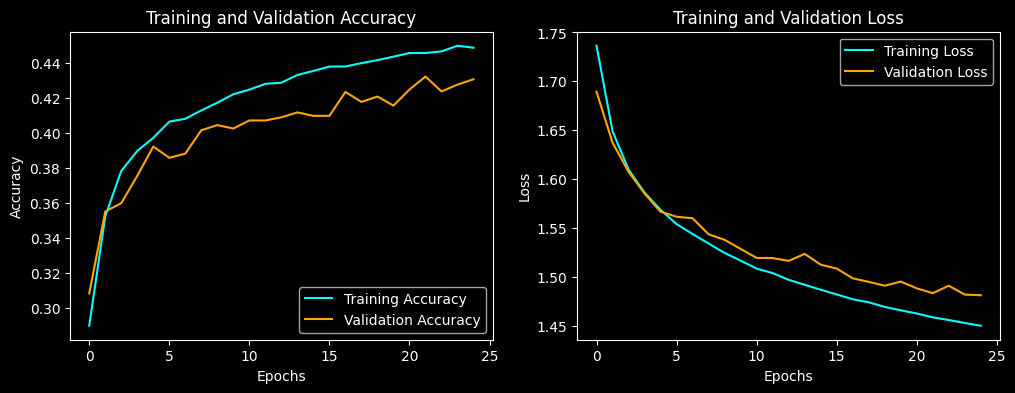

In [24]:
# Define class names (replace these with actual class names if available)
CLASS_NAMES = CLASS_NAMES# Ensure 'class_names' is defined in your code

# Function to plot accuracy and loss curves
def plot_training_curves(history):
    # Use a dark theme
    plt.style.use('dark_background')
    plt.figure(figsize=(12, 4))

    # Accuracy plot
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Training Accuracy', color='cyan')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy', color='orange')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.title('Training and Validation Accuracy')

    # Loss plot
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Training Loss', color='cyan')
    plt.plot(history.history['val_loss'], label='Validation Loss', color='orange')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.title('Training and Validation Loss')

    plt.show()

# Call the function to plot curves
plot_training_curves(history)

225/225 ━━━━━━━━━━━━━━━━━━━━ 36s 160ms/step


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/m

Classification Report:
               precision    recall  f1-score   support

       angry       0.13      0.05      0.07       958
   disgusted       0.00      0.00      0.00       111
     fearful       0.14      0.02      0.03      1024
       happy       0.24      0.47      0.32      1774
     neutral       0.15      0.15      0.15      1233
         sad       0.18      0.17      0.17      1247
   surprised       0.12      0.12      0.12       831

    accuracy                           0.19      7178
   macro avg       0.14      0.14      0.12      7178
weighted avg       0.17      0.19      0.16      7178

Precision: 0.17, Recall: 0.19, F1 Score: 0.16


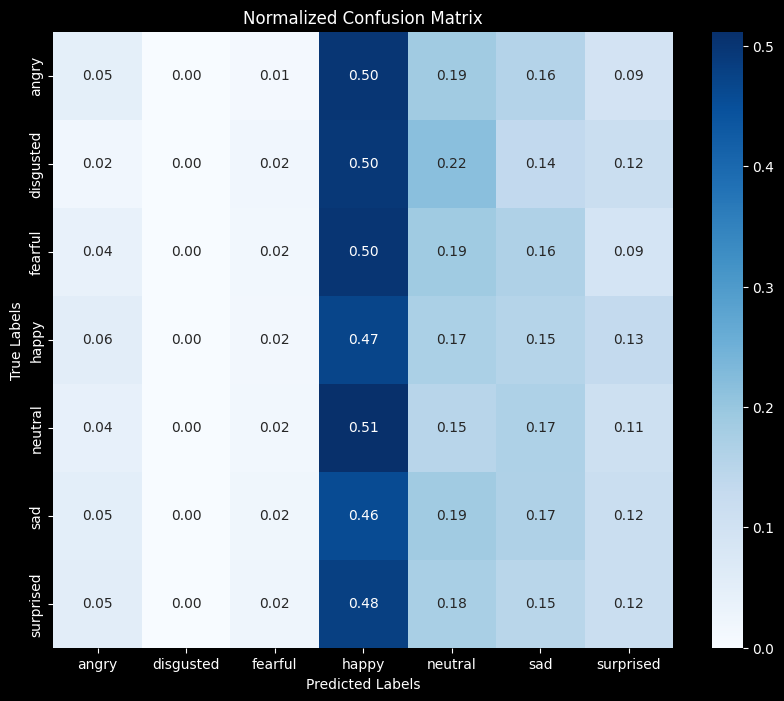

In [26]:
import numpy as np
from sklearn.metrics import classification_report, precision_score, recall_score, f1_score, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Extract true labels (Y_true) from val_dataset
Y_true = []
for _, labels in val_dataset:
    Y_true.extend(labels.numpy())  # Collect labels as a list
Y_true = np.array(Y_true)  # Convert to a NumPy array

# Predict on validation data
Y_pred = model.predict(val_dataset)
Y_pred_classes = np.argmax(Y_pred, axis=1)

# Generate a classification report
CLASS_NAMES = list(CLASS_NAMES)  # Ensure class names are available
print("Classification Report:\n", classification_report(Y_true, Y_pred_classes, target_names=CLASS_NAMES))

# Calculate precision, recall, and F1-score
precision = precision_score(Y_true, Y_pred_classes, average='weighted')
recall = recall_score(Y_true, Y_pred_classes, average='weighted')
f1 = f1_score(Y_true, Y_pred_classes, average='weighted')
print(f'Precision: {precision:.2f}, Recall: {recall:.2f}, F1 Score: {f1:.2f}')

# Calculate normalized confusion matrix
conf_matrix = confusion_matrix(Y_true, Y_pred_classes, normalize='true')

# Plot the confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, cmap='Blues', xticklabels=CLASS_NAMES, yticklabels=CLASS_NAMES, fmt='.2f')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Normalized Confusion Matrix')
plt.show()

# GUI Implementation


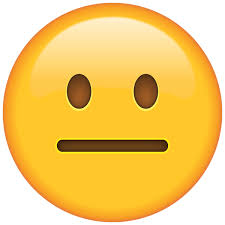

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


In [29]:
import numpy as np
import tensorflow as tf
from PIL import Image
from IPython.display import display, clear_output
import ipywidgets as widgets
import io

# Assuming the following are already defined:
# 1. `model`: Your trained Keras model.
# 2. `CLASS_NAMES`: A list of class names corresponding to your model's output.

# Define the prediction function
def predict_image(img):
    """
    Preprocess the uploaded image and make a prediction using the trained model.
    """
    # Resize the image
    img_resized = img.resize((256, 256))

    # Convert to numpy array and normalize
    img_array = np.array(img_resized).astype('float32') / 255.0

    # Add batch dimension
    img_array = np.expand_dims(img_array, axis=0)

    # Predict
    predictions = model.predict(img_array)
    confidence_scores = predictions[0]
    pred_index = np.argmax(confidence_scores)
    pred_class = CLASS_NAMES[pred_index]
    pred_confidence = confidence_scores[pred_index]

    # Update result label
    result_label.value = f"Prediction: {pred_class}\nConfidence: {pred_confidence:.2f}"

# Define widgets
upload_button = widgets.FileUpload(accept='image/*', multiple=False)
result_label = widgets.Label(value="Upload an image to predict.")

def on_upload_change(change):
    """
    Handle the image upload, display it, and predict the class.
    """
    try:
        # Clear previous outputs
        clear_output(wait=True)

        # Display widgets again
        display(widgets.VBox([upload_button, result_label]))

        for file_info in upload_button.value.values():
            # Convert uploaded file content to an image
            image_data = io.BytesIO(file_info['content'])
            img = Image.open(image_data)

            # Display the uploaded image
            display(img)

            # Predict and display results
            predict_image(img)

    except Exception as e:
        result_label.value = f"Error: {str(e)}"

# Attach the handler to the upload button
upload_button.observe(on_upload_change, names='value')

# Display the interface
display(widgets.VBox([upload_button, result_label]))
